Problem Statement
1) predict the number of household issues job, using features like job card, days,

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, v_measure_score
import warnings
import pickle

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/8071_source_data.csv')
df.head()

,srcStateName,srcDistrictName,srcBlockName,Village Name,srcYear,srcMonth,Number of Households issue Job Card Schedule Castes (SC),Number of Households issue Job Card Schedule Tribes (ST),Number of Households issue Job Card Others,Total number of Households issue Job Card,...,Total number of person days generated,Number of person days generated for woman,Families completed 100days Scheduled Caste (SCs),Families completed 100days Scheduled Tribe (STs),Families completed 100days Others,Total Families completed 100 days,YearCode,Year,MonthCode,Month
0,Meghalaya,ri bhoi,umsning,kdohhati,2016-2017,Jun-2016,0,135,0,135,...,8031,3758,0,1,0,1,2016,"Financial Year (Apr - Mar), 2016",201603,"June, 2016"
1,Meghalaya,west khasi hills,nongstoin,miangshiang,2021-2022,Jun-2021,0,62,0,62,...,3649,2583,0,3,0,3,2021,"Financial Year (Apr - Mar), 2021",202103,"June, 2021"
2,Meghalaya,west garo hills,selsella,jongnagre,2016-2017,Jun-2016,0,35,0,35,...,2114,356,0,0,0,0,2016,"Financial Year (Apr - Mar), 2016",201603,"June, 2016"
3,Meghalaya,west khasi hills,nongstoin,mawkohmah,2015-2016,Jun-2015,0,24,0,24,...,1363,908,0,0,0,0,2015,"Financial Year (Apr - Mar), 2015",201503,"June, 2015"
4,Meghalaya,west khasi hills,mawshynrut,rangseng,2019-2020,Jun-2019,0,119,0,119,...,9247,2007,0,0,0,0,2019,"Financial Year (Apr - Mar), 2019",201903,"June, 2019"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57053 entries, 0 to 57052
Data columns (total 28 columns):
 #   Column                                                            Non-Null Count  Dtype 
---  ------                                                            --------------  ----- 
 0   srcStateName                                                      57053 non-null  object
 1   srcDistrictName                                                   57053 non-null  object
 2   srcBlockName                                                      57053 non-null  object
 3   Village Name                                                      57053 non-null  object
 4   srcYear                                                           57053 non-null  object
 5   srcMonth                                                          57053 non-null  object
 6   Number of Households issue Job Card Schedule Castes (SC)          57053 non-null  int64 
 7   Number of Households issue Job Card Sche

In [6]:
df.drop(columns=['Number of household provided Employment to Schedule Castes (SCs)', 'Number of Household provided Employment to Schedule Tribes (STs)',
                 'Number of Household provided Employment to Others','Number of Employment provided to woman'],inplace=True)
df.drop(columns=['srcStateName','srcYear','srcMonth','Year','MonthCode','Month'],inplace=True)
df.drop(columns=['Village Name'],inplace=True)

In [7]:
temp_df = df['srcDistrictName']
for i in range(temp_df.shape[0]):
    if len(temp_df.iloc[i].split()) >= 2:
        str_list = temp_df.iloc[i].split()
        df.at[i,'srcDistrictName'] = str_list[-2].lower() + ' ' + str_list[-1].lower()
print(df['srcDistrictName'].unique())

['ri bhoi' 'khasi hills' 'garo hills' 'jaintia hills']


In [8]:
df = df[df['YearCode'] != 2022]

Exploratory Data Analasis

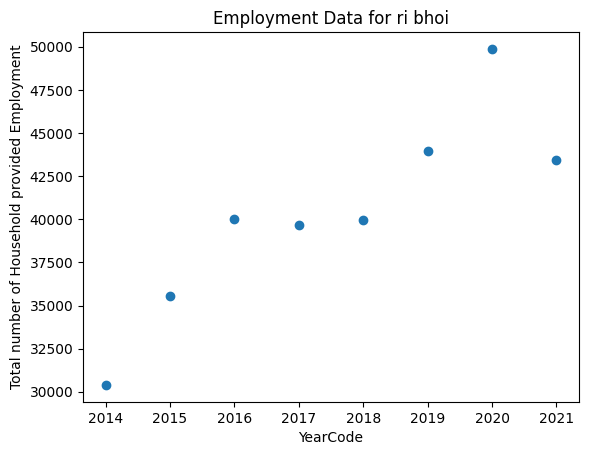

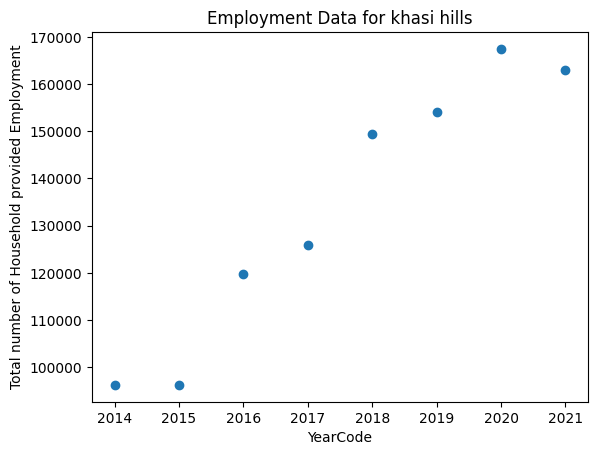

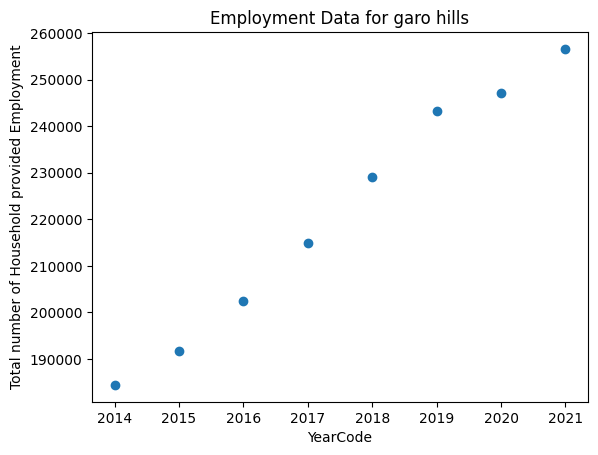

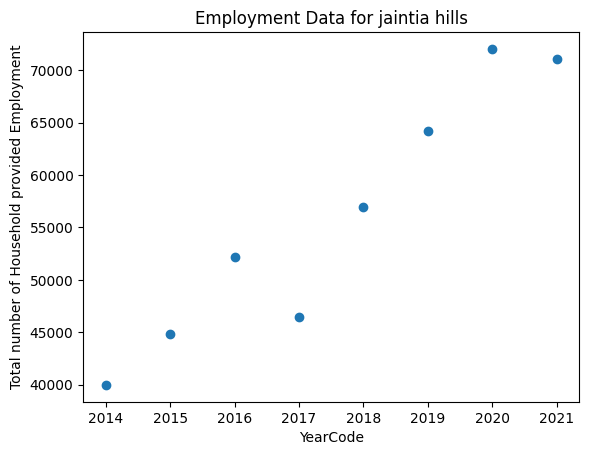

In [9]:
for i in df['srcDistrictName'].unique():
    dummy_df = df[['srcDistrictName', 'YearCode', 'Total number of Household provided Employment']][df['srcDistrictName'] == i]
    dummy_df = dummy_df.groupby(['srcDistrictName', 'YearCode']).sum()
    plt.scatter(dummy_df.index.get_level_values('YearCode'), dummy_df['Total number of Household provided Employment'])

    plt.xlabel('YearCode')
    plt.ylabel('Total number of Household provided Employment')
    plt.title(f"Employment Data for {i}")
    plt.show()

**Feature engeneering**

In [10]:
X = df.drop(columns=['Total number of Household provided Employment','srcBlockName'])
y = df['Total number of Household provided Employment']

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
year_train_index, year_test_index = X[X['YearCode'] < 2020].index, X[X['YearCode'] >= 2020].index

scaler = StandardScaler()
numeric_list = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_list]),columns=numeric_list)


encoder = OneHotEncoder(sparse_output=False)
X_encoded = X['srcDistrictName'].values.reshape(-1, 1)
X_encoded = encoder.fit_transform(X_encoded)
X_encoded = pd.DataFrame(X_encoded,columns=['0','1','2','3'])

X = pd.concat([X_scaled,X_encoded],axis=1)

In [11]:
X_new = X.drop(columns=['Number of Households issue Job Card Schedule Tribes (ST)','Number of person days generated Others',
                        'Number of person days generated Scheduled Tribe (STs)', 'Number of person days generated for woman', 
                        'Families completed 100days Scheduled Tribe (STs)','0','1','2','3'])

vif_data = pd.DataFrame()
vif_data["Feature"] = X_new.columns
vif_data["VIF"] = [variance_inflation_factor(X_new, i) for i in range(X_new.shape[1])]

vif_data

,Feature,VIF
0,Number of Households issue Job Card Schedule C...,3.951293
1,Number of Households issue Job Card Others,1.541546
2,Total number of Households issue Job Card,2.221179
3,Number of person days generated Scheduled Cast...,4.853739
4,Total number of person days generated,3.487827
5,Families completed 100days Scheduled Caste (SCs),1.506364
6,Families completed 100days Others,1.473208
7,Total Families completed 100 days,1.976456
8,YearCode,1.075171


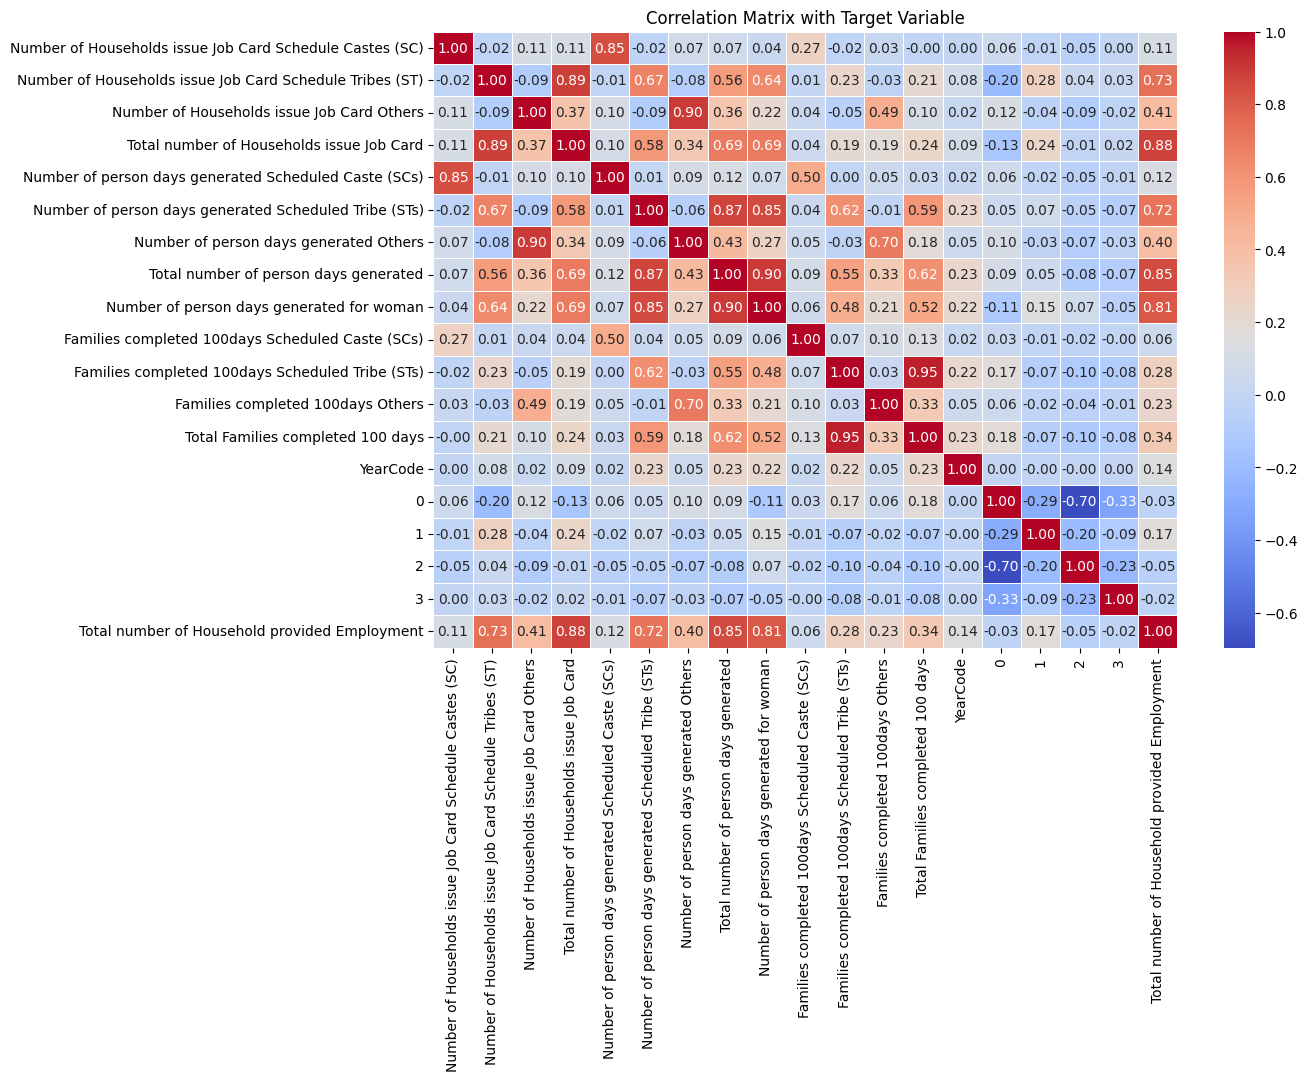

In [12]:
df_with_target = pd.concat([X,y],axis=1)
corr_matrix = df_with_target.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
plt.title('Correlation Matrix with Target Variable')
plt.show()

In [13]:
X = X.drop(columns=['Number of Households issue Job Card Schedule Tribes (ST)','Number of person days generated Others',
                        'Number of person days generated Scheduled Tribe (STs)', 'Number of person days generated for woman', 
                        'Families completed 100days Scheduled Tribe (STs)'])

X_train, X_test =  X.iloc[year_train_index], X.iloc[year_test_index]
y_train, y_test = y.iloc[year_train_index], y.iloc[year_test_index]

There is a high corelation of target variable with "total issues job cards" and "total days"

**Dicision Tree**

In [156]:
dt_regressor = DecisionTreeRegressor(splitter='best',random_state=42)

param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [8,9],
    'min_samples_split': [2], 
    'min_samples_leaf': [2],
    'min_weight_fraction_leaf': [0.0005,0.0049],
    'min_impurity_decrease': [0.0005,0.0049],
    'ccp_alpha' : [0.00015,0.00016]

}

r2_scorer = make_scorer(r2_score)

grid_search = GridSearchCV(dt_regressor, param_grid,scoring=r2_scorer, verbose=3, cv=3,n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [39]:
dt_regressor = DecisionTreeRegressor(splitter = 'best', random_state=42)

param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best'],
    'max_depth': [8, 9,10,11,12],
    'min_samples_split': [3,4,6,7,9], 
    'min_samples_leaf': [2,3,4,6,7,9],
    'min_weight_fraction_leaf': [0.0003,0.0005, 0.008, 0.015,0.05],
    'max_features': [11,10,9,8,7],
    'min_impurity_decrease': [0.0003,0.0005, 0.008, 0.015,0.05],
    'ccp_alpha': [0.00015, 0.0002,0.0008,0.001,0.005,0.01]

}

r2_scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(dt_regressor, param_grid, 
                                   n_iter=50, scoring=r2_scorer,
                                   verbose=3, cv=3, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 50 candidates, totalling 150 fits


({'splitter': 'best',
  'min_weight_fraction_leaf': 0.0003,
  'min_samples_split': 9,
  'min_samples_leaf': 3,
  'min_impurity_decrease': 0.0003,
  'max_features': 11,
  'max_depth': 12,
  'criterion': 'friedman_mse',
  'ccp_alpha': 0.001},
 0.9466517745968789)

In [16]:
dt_regressor = DecisionTreeRegressor(splitter = 'best', random_state=42)

param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best'],
    'max_depth': [8,9,10,11,12],
    'min_samples_split': [6,7,8,9], 
    'min_samples_leaf': [2,3,4,6],
    'min_weight_fraction_leaf': [0.0001,0.0002,0.0003,0.0004,0.0005],
    'max_features': [12,11,10],
    'min_impurity_decrease': [0.0002,0.0003,0.0004,0.0005],
    'ccp_alpha': [0.0008,0.001,0.0015,0.002]

}

r2_scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(dt_regressor, param_grid, 
                                   n_iter=50, scoring=r2_scorer,
                                   verbose=3, cv=3, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 50 candidates, totalling 150 fits


({'splitter': 'best',
  'min_weight_fraction_leaf': 0.0002,
  'min_samples_split': 7,
  'min_samples_leaf': 2,
  'min_impurity_decrease': 0.0004,
  'max_features': 10,
  'max_depth': 10,
  'criterion': 'poisson',
  'ccp_alpha': 0.001},
 0.948749651648773)

In [17]:

best_params = {'splitter': 'best',
  'min_weight_fraction_leaf': 0.0002,
  'min_samples_split': 7,
  'min_samples_leaf': 2,
  'min_impurity_decrease': 0.0004,
  'max_features': 10,
  'max_depth': 10,
  'criterion': 'poisson',
  'ccp_alpha': 0.001}

dt_regression = DecisionTreeRegressor(**best_params)

dt_regression.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.001, criterion='poisson', max_depth=10,
                      max_features=10, min_impurity_decrease=0.0004,
                      min_samples_leaf=2, min_samples_split=7,
                      min_weight_fraction_leaf=0.0002)

In [18]:
y_pred = dt_regression.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.960619132056278
Mean Squared Error (MSE): 192.9449205772957
Root Mean Squared Error (RMSE): 13.890461496195716


In [19]:
y_pred = dt_regression.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9534592189200871
Mean Squared Error (MSE): 350.37105386833423
Root Mean Squared Error (RMSE): 18.71820113868676


**OLS**

In [13]:
X_train_with_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_with_const).fit()
model_summary = model.summary()
print(model_summary)

p_values = model.pvalues
print("\nP-values of the features:\n", p_values)
significant_features = p_values[p_values < 0.05]
print("\nSignificant Features (p < 0.05):\n", significant_features)

                                          OLS Regression Results                                         
Dep. Variable:     Total number of Household provided Employment   R-squared:                       0.881
Model:                                                       OLS   Adj. R-squared:                  0.881
Method:                                            Least Squares   F-statistic:                 2.162e+04
Date:                                           Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                                                   11:38:30   Log-Likelihood:            -1.7502e+05
No. Observations:                                          38018   AIC:                         3.501e+05
Df Residuals:                                              38004   BIC:                         3.502e+05
Df Model:                                                     13                                         
Covariance Type:                              

**Ridge**

In [ ]:
ridge_regressor = Ridge(random_state=42)

param_grid = {
    'alpha': [0.1, 1, 10],  
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'], 
    'max_iter': [1000,2000],
    'tol':[0],
    'random_state':[42]
}

r2_scorer = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=ridge_regressor, param_grid=param_grid, 
                           scoring=r2_scorer, cv=5, verbose=1,n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

In [17]:
ridge_regressor = Ridge(random_state=42)

param_grid = {
    'alpha': [5, 7,10,12,15],  
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'], 
    'max_iter': [400,500,700,1000,1500],
    'tol':[0.0008,0.001,0.002,0.005]
}

r2_scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(ridge_regressor, param_grid, 
                                   n_iter=50, scoring=r2_scorer,
                                   verbose=3, cv=4, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 4 folds for each of 50 candidates, totalling 200 fits


({'tol': 0.0008, 'solver': 'sag', 'max_iter': 1000, 'alpha': 12},
 0.8795932326647928)

In [14]:
best_params = {'tol': 0.0008, 'solver': 'sag', 'max_iter': 1000, 'alpha': 12}

ridge_regressor = Ridge(random_state=42,**best_params)
ridge_regressor.fit(X_train, y_train)

Ridge(alpha=10, max_iter=500, random_state=42, solver='sag', tol=0.001)

In [19]:
y_pred = ridge_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8808730047780997
Mean Squared Error (MSE): 583.657746308399
Root Mean Squared Error (RMSE): 24.15900963012348


In [20]:
y_pred = ridge_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9271959095646668
Mean Squared Error (MSE): 548.088048800769
Root Mean Squared Error (RMSE): 23.411280375083482


**Lasso**

In [13]:
lasso_regressor = Lasso()

param_grid = {
    'alpha': [0.1, 1, 10],    
    'max_iter': [400,500,700,1000, 2000],  
    'selection': ['cyclic', 'random'] 
}

r2_scorer = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=lasso_regressor, param_grid=param_grid, 
                           scoring=r2_scorer, cv=5,verbose=1,n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({'alpha': 10, 'max_iter': 2000, 'selection': 'random'}, 31.78130182597178)

In [26]:
lasso_regressor = Lasso(random_state=42)

param_grid = {
    'alpha': [0.01, 0.04,0.05,0.08, 0.1],  
    'selection': ['cyclic', 'random'], 
    'max_iter': [400,500,700,1000,1500],
    'tol':[0,0.0001,0.0005,0.0008,0.0006,0.0004],
}

r2_scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(lasso_regressor, param_grid, 
                                   n_iter=50, scoring=r2_scorer,
                                   verbose=3, cv=4, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 4 folds for each of 50 candidates, totalling 200 fits


({'tol': 0.0008, 'selection': 'random', 'max_iter': 700, 'alpha': 0.04},
 0.8795906137098086)

In [27]:

best_params = {'tol': 0.0008, 'selection': 'random', 'max_iter': 700, 'alpha': 0.04}

lasso_regressor = Lasso(**best_params)
lasso_regressor.fit(X_train, y_train)

Lasso(alpha=0.04, max_iter=700, selection='random', tol=0.0008)

In [28]:
y_pred = lasso_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8808547231564341
Mean Squared Error (MSE): 583.7473163515309
Root Mean Squared Error (RMSE): 24.160863319664944


In [29]:
y_pred = lasso_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.92726561144809
Mean Squared Error (MSE): 547.5633149698155
Root Mean Squared Error (RMSE): 23.400070832581157


**SVM**

In [ ]:
svm_regressor = SVR()

param_dist = {
    'C': [1,2,3,4,5,6,7],    
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'gamma': ['scale', 'auto'],      
    'degree': [1,2, 3,4],             
    'epsilon': [0.005,0.01,0.02], 
}

r2_scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(estimator=svm_regressor, param_distributions=param_dist, n_iter=10, scoring=r2_scorer, 
                                   cv=3,verbose=1, n_jobs=-1, random_state=42)       

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

In [14]:
best_params = {'kernel': 'poly', 'gamma': 'scale', 'epsilon': 0.01, 'degree': 2, 'C': 5}

svm_regressor = SVR(**best_params)
svm_regressor.fit(X_train, y_train)

SVR(C=0.1, gamma='auto', kernel='sigmoid')

In [50]:
y_pred = svm_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8378061814353327
Mean Squared Error (MSE): 794.6618516841747
Root Mean Squared Error (RMSE): 28.189747279537197


In [51]:
y_pred = svm_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9189231719568696
Mean Squared Error (MSE): 610.3673601222357
Root Mean Squared Error (RMSE): 24.705613939391096


**RandomForest**

In [38]:
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42)

param_dict = {
    'n_estimators': [200,230,250,280,300],   
    'max_depth': [9,10,11],         
    'min_samples_split': [12,13,14],    
    'min_samples_leaf': [3,4,5],   
    'min_weight_fraction_leaf':[0.0003,0.0004,0.0005],
    'min_impurity_decrease':[0.00045,0.0005,0.00055],
    'max_features': [12,11,10],    
    'bootstrap': [True, False],
    'max_samples':[0.4,0.45,0.5,0.55,0.6],                    
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'ccp_alpha':[0.0009,0.001,0.002,0.003]        
}

random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dict, n_iter=50,             
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)       

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 50 candidates, totalling 150 fits


({'n_estimators': 280,
  'min_weight_fraction_leaf': 0.0004,
  'min_samples_split': 12,
  'min_samples_leaf': 4,
  'min_impurity_decrease': 0.00045,
  'max_samples': 0.45,
  'max_features': 12,
  'max_depth': 11,
  'criterion': 'friedman_mse',
  'ccp_alpha': 0.001,
  'bootstrap': True},
 0.9579444227203728)

In [12]:
best_params = {'n_estimators': 280,'min_weight_fraction_leaf': 0.0004,'min_samples_split': 12,'min_samples_leaf': 4,
  'min_impurity_decrease': 0.00045,'max_samples': 0.45,'max_features': 12,'max_depth': 11,'criterion': 'friedman_mse',
  'ccp_alpha': 0.001,'bootstrap': True}
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42,**best_params)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0.001, criterion='friedman_mse', max_depth=11,
                      max_features=12, max_samples=0.45,
                      min_impurity_decrease=0.00045, min_samples_leaf=4,
                      min_samples_split=12, min_weight_fraction_leaf=0.0004,
                      n_estimators=280, n_jobs=-1, random_state=42)

In [46]:
y_pred = rf_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9688658722963058
Mean Squared Error (MSE): 152.5403606039695
Root Mean Squared Error (RMSE): 12.35072308020747


In [47]:
y_pred = rf_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9586389725146476
Mean Squared Error (MSE): 311.37652727050414
Root Mean Squared Error (RMSE): 17.64586431066793


**XGBoost**

In [53]:
xg_regressor = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', random_state=42)

param_dist = {
    'lambda': [0,0.0001,0.001], 
    'alpha':[0.009,0.1,0.11,0.12],
    'updater': ['shotgun','coord_descent'],                 
    'feature_selector': ['cyclic','shuffle','random','greedy','thrifty'],   
    'top_k':[9,10,11]        
}

random_search = RandomizedSearchCV(estimator=xg_regressor, param_distributions=param_dist, n_iter=50,
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 50 candidates, totalling 150 fits


({'updater': 'coord_descent',
  'top_k': 11,
  'lambda': 0,
  'feature_selector': 'shuffle',
  'alpha': 0.1},
 0.8796074390411377)

In [54]:

best_params = {'updater': 'coord_descent',
  'top_k': 11,
  'lambda': 0,
  'feature_selector': 'shuffle',
  'alpha': 0.1}
xg_regressor = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', random_state=42,**best_params)
xg_regressor.fit(X_train, y_train)

XGBRegressor(alpha=0.1, base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_selector='shuffle', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, ...)

In [55]:
y_pred = xg_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8808008432388306
Mean Squared Error (MSE): 584.0111507596516
Root Mean Squared Error (RMSE): 24.166322656946623


In [56]:
y_pred = xg_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9273529052734375
Mean Squared Error (MSE): 546.9062083103559
Root Mean Squared Error (RMSE): 23.386025919560506


**Modeling without Year**

In [57]:
X = df.drop(columns=['Total number of Household provided Employment','srcBlockName'])
y = df['Total number of Household provided Employment']

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

year_train_index, year_test_index = X[X['YearCode'] < 2020].index, X[X['YearCode'] >= 2020].index
X = X.drop(columns=['YearCode'])

scaler = StandardScaler()
numeric_list = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_list]),columns=numeric_list)


encoder = OneHotEncoder(sparse_output=False)
X_encoded = X['srcDistrictName'].values.reshape(-1, 1)
X_encoded = encoder.fit_transform(X_encoded)
X_encoded = pd.DataFrame(X_encoded,columns=['0','1','2','3'])


X = pd.concat([X_scaled,X_encoded],axis=1)

X_train, X_test =  X.iloc[year_train_index], X.iloc[year_test_index]
y_train, y_test = y.iloc[year_train_index], y.iloc[year_test_index]

**Dicision Tree**

In [71]:
dt_regressor = DecisionTreeRegressor()

param_distributions = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best'],
    'max_depth': [9,10,11,12],
    'min_samples_split': [10,11,12], 
    'min_samples_leaf': [2,3,4,5],
    'min_weight_fraction_leaf': [0.0001,0.0002,0.0003,0.0004],
    'min_impurity_decrease': [0.00001,0.00005,0.0001],
    'ccp_alpha': [0.0009,0.0001, 0.0002],
    'random_state': [42],
    'max_features': [None,16,15]
}

random_search = RandomizedSearchCV(dt_regressor, param_distributions, 
                                   n_iter=50, 
                                   verbose=3, cv=3, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 50 candidates, totalling 150 fits


({'splitter': 'best',
  'random_state': 42,
  'min_weight_fraction_leaf': 0.0002,
  'min_samples_split': 12,
  'min_samples_leaf': 2,
  'min_impurity_decrease': 1e-05,
  'max_features': 15,
  'max_depth': 12,
  'criterion': 'friedman_mse',
  'ccp_alpha': 0.0001},
 0.9474357655953973)

In [78]:
best_params = {'splitter': 'best',
  'random_state': 42,
  'min_weight_fraction_leaf': 0.0002,
  'min_samples_split': 12,
  'min_samples_leaf': 2,
  'min_impurity_decrease': 1e-05,
  'max_features': 15,
  'max_depth': 12,
  'criterion': 'friedman_mse',
  'ccp_alpha': 0.0001}

dt_regression = DecisionTreeRegressor(**best_params)

dt_regression.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0001, criterion='friedman_mse', max_depth=12,
                      max_features=15, min_impurity_decrease=1e-05,
                      min_samples_leaf=2, min_samples_split=12,
                      min_weight_fraction_leaf=0.0002, random_state=42)

In [79]:
y_pred = dt_regression.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9725599801484943
Mean Squared Error (MSE): 134.44123320121508
Root Mean Squared Error (RMSE): 11.594879611329093


In [80]:
y_pred = dt_regression.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9512271638599391
Mean Squared Error (MSE): 367.174542455545
Root Mean Squared Error (RMSE): 19.16179904016178


**OLS**

In [81]:
X_train_with_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_with_const).fit()
model_summary = model.summary()
print(model_summary)

p_values = model.pvalues
print("\nP-values of the features:\n", p_values)
significant_features = p_values[p_values < 0.05]
print("\nSignificant Features (p < 0.05):\n", significant_features)

                                          OLS Regression Results                                         
Dep. Variable:     Total number of Household provided Employment   R-squared:                       0.882
Model:                                                       OLS   Adj. R-squared:                  0.882
Method:                                            Least Squares   F-statistic:                 1.780e+04
Date:                                           Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                                                   13:06:34   Log-Likelihood:            -1.7480e+05
No. Observations:                                          38018   AIC:                         3.496e+05
Df Residuals:                                              38001   BIC:                         3.498e+05
Df Model:                                                     16                                         
Covariance Type:                              

**Ridge**

In [104]:
ridge_regressor = Ridge(random_state=42)

param_grid = {
    'alpha': [20,15,10,25,30],  
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'], 
    'max_iter': [600,700,800,900],
    'tol':[0.008,0.009,0.01]
}

r2_scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(ridge_regressor, param_grid, 
                                   n_iter=100, scoring=r2_scorer,
                                   verbose=3, cv=3, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 100 candidates, totalling 300 fits


({'tol': 0.009, 'solver': 'sag', 'max_iter': 900, 'alpha': 20},
 0.8809518107065003)

In [111]:
best_params = {'tol': 0.009, 'solver': 'sag', 'max_iter': 900, 'alpha': 20}

ridge_regressor = Ridge(random_state=42,**best_params)
ridge_regressor.fit(X_train, y_train)

Ridge(alpha=20, max_iter=900, random_state=42, solver='sag', tol=0.009)

In [112]:
y_pred = ridge_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8822458240772654
Mean Squared Error (MSE): 576.9316753893168
Root Mean Squared Error (RMSE): 24.019402061444342


In [113]:
y_pred = ridge_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9311377429102063
Mean Squared Error (MSE): 518.4129064545629
Root Mean Squared Error (RMSE): 22.76868258056585


**Lasso**

In [121]:
lasso_regressor = Lasso(random_state=42)

param_grid = {
    'alpha': [0.04, 0.05, 0.06],  
    'selection': ['cyclic', 'random'], 
    'max_iter': [1000,1500,2000,2500,3000],
    'tol':[0,0.0001,0.0005,0.001],
}

r2_scorer = make_scorer(r2_score)

random_search = RandomizedSearchCV(lasso_regressor, param_grid, 
                                   n_iter=100, scoring=r2_scorer,
                                   verbose=3, cv=3, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 100 candidates, totalling 300 fits


({'tol': 0.0001, 'selection': 'random', 'max_iter': 1500, 'alpha': 0.06},
 0.8809049002578778)

In [122]:
best_params = {'tol': 0.0001, 'selection': 'random', 'max_iter': 1500, 'alpha': 0.06}

lasso_regressor = Lasso(random_state=42,**best_params)
lasso_regressor.fit(X_train, y_train)

Lasso(alpha=0.06, max_iter=1500, random_state=42, selection='random')

In [123]:
y_pred = lasso_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8822380871370062
Mean Squared Error (MSE): 576.9695822055386
Root Mean Squared Error (RMSE): 24.020191135907695


In [124]:
y_pred = lasso_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9312305046798769
Mean Squared Error (MSE): 517.7145718275102
Root Mean Squared Error (RMSE): 22.753341992496622


**RandomForest**

In [138]:
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42)

param_dict = {
    'n_estimators': [40,50,70,100],   
    'max_depth': [9,10,11,12],         
    'min_samples_split': [10,12,15,17],    
    'min_samples_leaf': [3,5,7,10],   
    'min_weight_fraction_leaf':[0.0002,0.0003,0.0005, 0.008],
    'min_impurity_decrease':[0.0003,0.0004,0.0005, 0.0006,0.008],
    'max_features': [16,11,10,14],    
    'bootstrap': [True, False],
    'max_samples':[0.3,0.5],                    
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'ccp_alpha':[0.0009,0.001,0.0015]        
}

random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dict, n_iter=50,             
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)       

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

Fitting 3 folds for each of 50 candidates, totalling 150 fits


({'n_estimators': 50,
  'min_weight_fraction_leaf': 0.0003,
  'min_samples_split': 12,
  'min_samples_leaf': 3,
  'min_impurity_decrease': 0.0006,
  'max_samples': 0.5,
  'max_features': 16,
  'max_depth': 10,
  'criterion': 'friedman_mse',
  'ccp_alpha': 0.0015,
  'bootstrap': True},
 0.9576907353215408)

In [142]:
best_params = {'n_estimators': 50,
  'min_weight_fraction_leaf': 0.0003,
  'min_samples_split': 12,
  'min_samples_leaf': 3,
  'min_impurity_decrease': 0.0006,
  'max_samples': 0.5,
  'max_features': 16,
  'max_depth': 10,
  'criterion': 'friedman_mse',
  'ccp_alpha': 0.0015,
  'bootstrap': True}

rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42,**best_params)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0.0015, criterion='friedman_mse', max_depth=10,
                      max_features=16, max_samples=0.5,
                      min_impurity_decrease=0.0006, min_samples_leaf=3,
                      min_samples_split=12, min_weight_fraction_leaf=0.0003,
                      n_estimators=50, n_jobs=-1, random_state=42)

In [143]:
y_pred = rf_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9694085756534326
Mean Squared Error (MSE): 149.88140813274654
Root Mean Squared Error (RMSE): 12.242606263894405


In [144]:
y_pred = rf_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.9594356377990299
Mean Squared Error (MSE): 305.37902467616544
Root Mean Squared Error (RMSE): 17.475097272294807


**XGBoost**

In [ ]:
xg_regressor = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', random_state=42)

param_dist = {
    'lambda': [1,2,3], 
    'alpha':[1,2,3],
    'updater': ['shotgun','coord_descent'],                 
    'feature_selector': ['cyclic','shuffle','random','greedy','thrifty'],   
    'top_k':[9,10,11]        
}

random_search = RandomizedSearchCV(estimator=xg_regressor, param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error',
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_params, best_score

In [174]:
best_params = {'updater': 'coord_descent','top_k': 9,'lambda': 1,'feature_selector': 'greedy','alpha': 1}
xg_regressor = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', random_state=42,**best_params)
xg_regressor.fit(X_train, y_train)

XGBRegressor(alpha=1, base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_selector='greedy', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, ...)

In [175]:
y_pred = xg_regressor.predict(X_train)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8109834790229797
Mean Squared Error (MSE): 926.0785595231772
Root Mean Squared Error (RMSE): 30.431538895086742


In [176]:
y_pred = xg_regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared (R²): 0.8640066981315613
Mean Squared Error (MSE): 1023.7928029820378
Root Mean Squared Error (RMSE): 31.996762382810513


*Saving Models*

In [13]:
with open('model.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)

In [12]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [14]:
cols = X_train.drop(columns=['0', '1', '2', '3']).columns
cols

Index(['Number of Households issue Job Card Schedule Castes (SC)',
       'Number of Households issue Job Card Others',
       'Total number of Households issue Job Card',
       'Number of person days generated Scheduled Caste (SCs)',
       'Total number of person days generated',
       'Families completed 100days Scheduled Caste (SCs)',
       'Families completed 100days Others',
       'Total Families completed 100 days', 'YearCode'],
      dtype='object')

In [15]:
new_df = df[cols]
new_df

,Number of Households issue Job Card Schedule Castes (SC),Number of Households issue Job Card Others,Total number of Households issue Job Card,Number of person days generated Scheduled Caste (SCs),Total number of person days generated,Families completed 100days Scheduled Caste (SCs),Families completed 100days Others,Total Families completed 100 days,YearCode
0,0,0,135,0,8031,0,0,1,2016
1,0,0,62,0,3649,0,0,3,2021
2,0,0,35,0,2114,0,0,0,2016
3,0,0,24,0,1363,0,0,0,2015
4,0,0,119,0,9247,0,0,0,2019
...,...,...,...,...,...,...,...,...,...
57048,0,1,30,0,2372,0,0,0,2021
57049,5,0,56,316,4344,0,0,23,2020
57050,0,0,81,0,7700,0,0,25,2018
57051,0,0,105,0,8793,0,0,61,2016


In [16]:
for i in cols:
    print('Please input "',i ,'" with the range of (', new_df[i].max(),',',new_df[i].min(),')')

Please input " Number of Households issue Job Card Schedule Castes (SC) " with the range of ( 210 , 0 )
Please input " Number of Households issue Job Card Others " with the range of ( 1303 , 0 )
Please input " Total number of Households issue Job Card " with the range of ( 1626 , 0 )
Please input " Number of person days generated Scheduled Caste (SCs) " with the range of ( 15119 , 0 )
Please input " Total number of person days generated " with the range of ( 124099 , 0 )
Please input " Families completed 100days Scheduled Caste (SCs) " with the range of ( 145 , 0 )
Please input " Families completed 100days Others " with the range of ( 645 , 0 )
Please input " Total Families completed 100 days " with the range of ( 852 , 0 )
Please input " YearCode " with the range of ( 2021 , 2014 )


In [18]:
df['srcDistrictName'].unique()

array(['ri bhoi', 'khasi hills', 'garo hills', 'jaintia hills'],
      dtype=object)

In [25]:
X.columns

Index(['srcDistrictName',
       'Number of Households issue Job Card Schedule Castes (SC)',
       'Number of Households issue Job Card Others',
       'Number of person days generated Scheduled Caste (SCs)',
       'Total number of person days generated',
       'Families completed 100days Scheduled Caste (SCs)',
       'Families completed 100days Others',
       'Total Families completed 100 days', 'YearCode'],
      dtype='object')

In [20]:
X

,srcDistrictName,Number of Households issue Job Card Schedule Castes (SC),Number of Households issue Job Card Others,Total number of Households issue Job Card,Number of person days generated Scheduled Caste (SCs),Total number of person days generated,Families completed 100days Scheduled Caste (SCs),Families completed 100days Others,Total Families completed 100 days,YearCode
0,ri bhoi,0,0,135,0,8031,0,0,1,2016
1,khasi hills,0,0,62,0,3649,0,0,3,2021
2,garo hills,0,0,35,0,2114,0,0,0,2016
3,khasi hills,0,0,24,0,1363,0,0,0,2015
4,khasi hills,0,0,119,0,9247,0,0,0,2019
...,...,...,...,...,...,...,...,...,...,...
50703,khasi hills,0,1,30,0,2372,0,0,0,2021
50704,ri bhoi,5,0,56,316,4344,0,0,23,2020
50705,ri bhoi,0,0,81,0,7700,0,0,25,2018
50706,khasi hills,0,0,105,0,8793,0,0,61,2016


In [21]:
X_new

,srcDistrictName,Number of Households issue Job Card Schedule Castes (SC),Number of Households issue Job Card Others,Number of Households issue Job Card Others,Number of person days generated Scheduled Caste (SCs),Total number of person days generated,Families completed 100days Scheduled Caste (SCs),Families completed 100days Others,Total Families completed 100 days,YearCode
0,ri bhoi,1,1,1,1,1,1,1,1,1


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

X = pd.read_csv('X.csv').drop(columns=['Unnamed: 0'])

with open('index.pkl', 'rb') as file:
    index = pickle.load(file)

# x0 = input('Please input " srcDistrictName " with the range of ') # string 4 unique values, ['ri bhoi', 'khasi hills', 'garo hills', 'jaintia hills']
# x1 = input('Please input " Number of Households issue Job Card Schedule Castes (SC) " with the range of ( 210 , 0 )')  
# x2 = input('Please input " Number of Households issue Job Card Others " with the range of ( 1303 , 0 )')
# x3 = input('job issues in SC ( 1626 , 0 )')
# x4 = input('Please input " Number of person days generated Scheduled Caste (SCs) " with the range of ( 15119 , 0 )')
# x5 = input('Please input " Total number of person days generated " with the range of ( 124099 , 0 )')
# x6 = input('Please input " Families completed 100days Scheduled Caste (SCs) " with the range of ( 145 , 0 )')
# x7 = input('Please input " Families completed 100days Others " with the range of ( 645 , 0 )')
# x8 = input('Please input " Total Families completed 100 days " with the range of ( 852 , 0 )')
# x9 = input('Please input " YearCode " with the range of ( 2021 , 2014 )')

x0 = 'ri bhoi'
x1 = 1
x2 = 1
x3 = 1
x4 = 1
x5 = 1
x6 = 1
x7 = 1
x8 = 1
x9 =1


X_new = pd.DataFrame([[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9]],columns=['srcDistrictName','Number of Households issue Job Card Schedule Castes (SC)',
       'Number of Households issue Job Card Others','Number of Households issue Job Card Others',
       'Number of person days generated Scheduled Caste (SCs)',
       'Total number of person days generated',
       'Families completed 100days Scheduled Caste (SCs)',
       'Families completed 100days Others',
       'Total Families completed 100 days', 'YearCode'])
# X = X.reset_index(drop=True)
# X_new = X_new.reset_index(drop=True)
X = pd.concat([X, X_new], axis=0, ignore_index=True)

scaler = StandardScaler()
numeric_list = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_list]),columns=numeric_list)

encoder = OneHotEncoder(sparse_output=False)
X_encoded = X['srcDistrictName'].values.reshape(-1, 1)
X_encoded = encoder.fit_transform(X_encoded)
X_encoded = pd.DataFrame(X_encoded,columns=['0','1','2','3'])

X = pd.concat([X_scaled,X_encoded],axis=1)
user_input = X.iloc[-1]

with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

prediction = model.predict(np.reshape(user_input, (1, -1)))[0]
prediction

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [14]:
y.to_csv('y.csv')

In [ ]:
Please input " Number of Households issue Job Card Schedule Castes (SC) " with the range of ( 210 , 0 )
Please input " Number of Households issue Job Card Others " with the range of ( 1303 , 0 )
Please input " Total number of Households issue Job Card " with the range of ( 1626 , 0 )
Please input " Number of person days generated Scheduled Caste (SCs) " with the range of ( 15119 , 0 )
Please input " Total number of person days generated " with the range of ( 124099 , 0 )
Please input " Families completed 100days Scheduled Caste (SCs) " with the range of ( 145 , 0 )
Please input " Families completed 100days Others " with the range of ( 645 , 0 )
Please input " Total Families completed 100 days " with the range of ( 852 , 0 )
Please input " YearCode " with the range of ( 2021 , 2014 )

In [ ]:
checl these columes : x0 = input('Please input " srcDistrictName " with the range of ') # string 4 unique values, ['ri bhoi', 'khasi hills', 'garo hills', 'jaintia hills']
x1 = input('Please input " Number of Households issue Job Card Schedule Castes (SC) " with the range of ( 210 , 0 )')  
x2 = input('Please input " Number of Households issue Job Card Others " with the range of ( 1303 , 0 )')
x3 = input('job issues in SC ( 1626 , 0 )')
x4 = input('Please input " Number of person days generated Scheduled Caste (SCs) " with the range of ( 15119 , 0 )')
x5 = input('Please input " Total number of person days generated " with the range of ( 124099 , 0 )')
x6 = input('Please input " Families completed 100days Scheduled Caste (SCs) " with the range of ( 145 , 0 )')
x7 = input('Please input " Families completed 100days Others " with the range of ( 645 , 0 )')
x8 = input('Please input " Total Families completed 100 days " with the range of ( 852 , 0 )')
x9 = input('Please input " YearCode " with the range of ( 2021 , 2014 )')


X_new = pd.DataFrame([[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9]],columns=['srcDistrictName','Number of Households issue Job Card Schedule Castes (SC)',
       'Number of Households issue Job Card Others',
       'Number of person days generated Scheduled Caste (SCs)',
       'Total number of person days generated',
       'Families completed 100days Scheduled Caste (SCs)',
       'Families completed 100days Others',
       'Total Families completed 100 days', 'YearCode'])

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

X = pd.read_csv('X.csv').drop(columns=['Unnamed: 0'])

with open('index.pkl', 'rb') as file:
    index = pickle.load(file)

x0 = input('Please input " srcDistrictName " with the range of ') # string 4 unique values, ['ri bhoi', 'khasi hills', 'garo hills', 'jaintia hills']
x1 = input('Please input " Number of Households issue Job Card Schedule Castes (SC) " with the range of ( 210 , 0 )')  
x2 = input('Please input " Number of Households issue Job Card Others " with the range of ( 1303 , 0 )')
x3 = input('job issues in SC ( 1626 , 0 )')
x4 = input('Please input " Number of person days generated Scheduled Caste (SCs) " with the range of ( 15119 , 0 )')
x5 = input('Please input " Total number of person days generated " with the range of ( 124099 , 0 )')
x6 = input('Please input " Families completed 100days Scheduled Caste (SCs) " with the range of ( 145 , 0 )')
x7 = input('Please input " Families completed 100days Others " with the range of ( 645 , 0 )')
x8 = input('Please input " Total Families completed 100 days " with the range of ( 852 , 0 )')
x9 = input('Please input " YearCode " with the range of ( 2021 , 2014 )')

X_new = pd.DataFrame([[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9]], columns=[
    'srcDistrictName',
    'Number of Households issue Job Card Schedule Castes (SC)',
    'Number of Households issue Job Card Others',
    'Job Issues in SC',  
    'Number of person days generated Scheduled Caste (SCs)',
    'Total number of person days generated',
    'Families completed 100days Scheduled Caste (SCs)',
    'Families completed 100days Others',
    'Total Families completed 100 days',
    'YearCode'
])


X = pd.concat([X, X_new], axis=0, ignore_index=True).drop(columns='Job Issues in SC')


scaler = StandardScaler()
numeric_list = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_list]), columns=numeric_list)


encoder = OneHotEncoder(sparse_output=False)
X_encoded = X['srcDistrictName'].values.reshape(-1, 1)
X_encoded = encoder.fit_transform(X_encoded)
X_encoded = pd.DataFrame(X_encoded, columns=['0', '1', '2', '3'])


X = pd.concat([X_scaled, X_encoded], axis=1)

user_input = X.iloc[-1]

with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

prediction = model.predict(np.reshape(user_input, (1, -1)))[0]
print(prediction)


0.0056274629358764
